##  资本资产定价模型

$E(r_t) - r_s = \beta_i*E(r_m-r_s)$

$E(r_t)$预期的组合收益，$r_s$为无风险收益率，$r_m$为基准收益。

在资本资产定价模型下：任何股票的超额收益仅与$\beta$相关，即预期超额收益率与$\beta$成正比。$\beta$为先验概念，值由线性回归定义：

$r_p(t) = \alpha_p + \beta_p r_m(t)+\epsilon_p(t)$

$r_p(t)$表示股票或者组合的超额收益，$r_m(t)$时刻$t$市场的超额收益。对历史数据回归得到的$\alpha,\beta$称为历史$\alpha,\beta$值。

$\beta$将任意的组合收益分解为两个不相关的部分，市场收益和残差收益。

股票受到自身特性的影响和市场因素(市场-系统性风险)的影响。

这里对CAPM的定价公式做一个简单的展开  
$r_p(t) = \alpha_p + \beta_p r_m(t)+\epsilon_p(t)$
$r_p(t)$平安银行收益率
$r_m(t)$ HS300指数相对于无风险利率的超额收益率

In [26]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import linear_model
# from CAL.PyCAL import font
import tushare as ts
sns.set_style('white')

%matplotlib inline
#无风险收益率
#取13国债 13国债01
s = 3.15/100
#交易日设定为260
#每日无风险利率为
r_s = np.power((1.+s), (1./260))- 1.
print r_s

0.000119291935983


In [168]:
#取平安银行
tmp = ts.get_h_data("000001",start="2012-12-31", end='2016-12-31')
tmp = tmp.set_index(pd.Series(tmp.index.values).apply(lambda x: pd.to_datetime(x).date()))
tmp = tmp.sort_index(ascending=True)
tmp['ret'] = tmp.close.pct_change().dropna()
tmp.dropna(axis = 0, how = 'any', inplace=True)
# tmp.reset_index(drop=True,inplace= True)

[Getting data:]################

In [102]:
#基准收益率设置为HS300指数日间收益率
# r_m = DataAPI.MktIdxdGet(ticker=u"000300",beginDate=u"20130101",endDate=u"20161231",exchangeCD=u"XSHE,XSHG",field=['tradeDate','CHGPct'] ,pandas="1")
r_m = ts.get_hist_data("hs300", "20130101","20161231")
r_m = r_m.set_index(pd.Series(r_m.index.values).apply(lambda x: pd.to_datetime(x).date()))
r_m = r_m.sort_index(ascending=True)
#基准相对于无风险利率的超额收益率为
# r_m['alpha'] = r_m.p_change / 100 - r_s# p_change 不准确
r_m['alpha'] = r_m.close.pct_change().dropna() - r_s
r_m.dropna(axis = 0, how = 'any', inplace=True)
r_m = r_m.loc[tmp.index.values]

股票和基准的时间序列

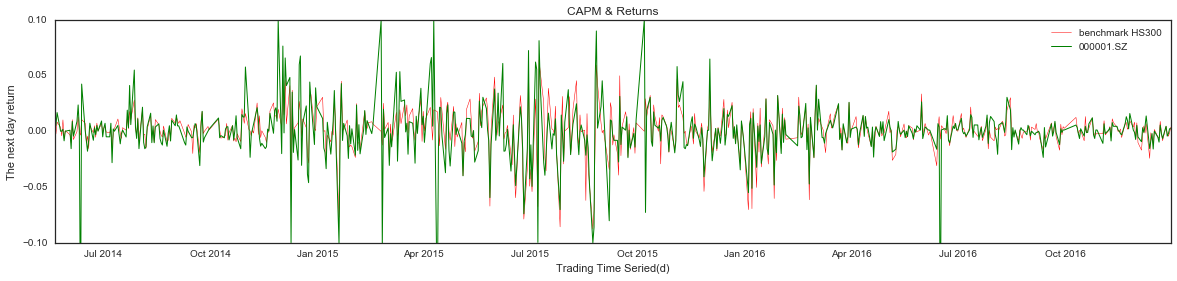

In [141]:
plt.figure(figsize=(20,4))
plt.plot(r_m.alpha, label="benchmark HS300", color='r', linewidth=.5)
plt.plot(tmp.ret, label = '000001.SZ', color='g', linewidth=1.)
plt.xlabel("Trading Time Seried(d)")
plt.ylabel("The next day return")
plt.title("CAPM & Returns")
plt.axis('tight')
plt.ylim([-0.1, 0.1])
plt.legend()
plt.show()

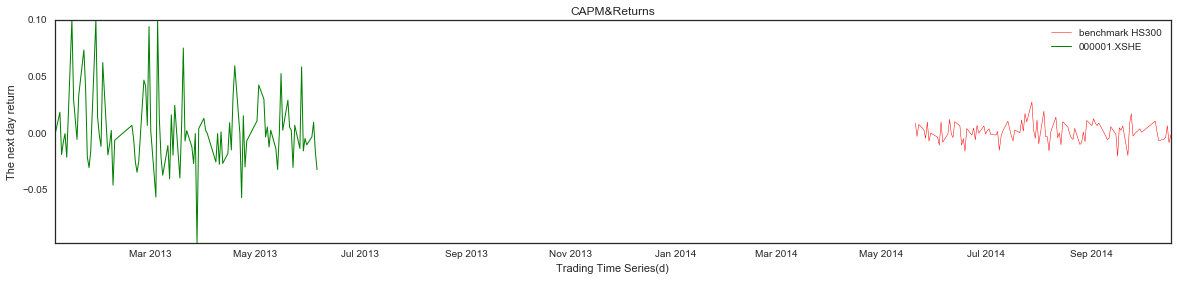

In [167]:
plt.figure(figsize=(20,4))
plt.plot(r_m.index[:100], r_m.alpha[:100], label="benchmark HS300",color="red",linewidth=.5)
plt.plot(tmp.index[:100], tmp['ret'][:100],label="000001.XSHE",color="green",linewidth=1.)
plt.xlabel("Trading Time Series(d)")
plt.ylabel("The next day return")
plt.title("CAPM&Returns")
plt.axis('tight')
plt.legend()
plt.show()

大体上看这个时间序列相关性很高。

这里对CAPM的定价公式做一个简单的展开  

$r_p(t) = \alpha_p + \beta_p r_m(t)+\epsilon_p(t)$

$r_p(t)$平安银行收益率

$r_m(t)$ HS300指数相对于无风险利率的超额收益率

使用线性回归利用历史数据估计$\beta$和$\alpha+\epsilon$

In [119]:
rm = r_m['alpha'].values
rp = tmp['ret'].values
beta, alpha, rvalue, pvalue, stderr = stats.linregress(rm, rp)

In [120]:
print beta,'---',alpha

0.93246075627 --- -0.00068289140099


查看拟合值与真实值的情况
$r_e = \beta *r_m +\alpha$

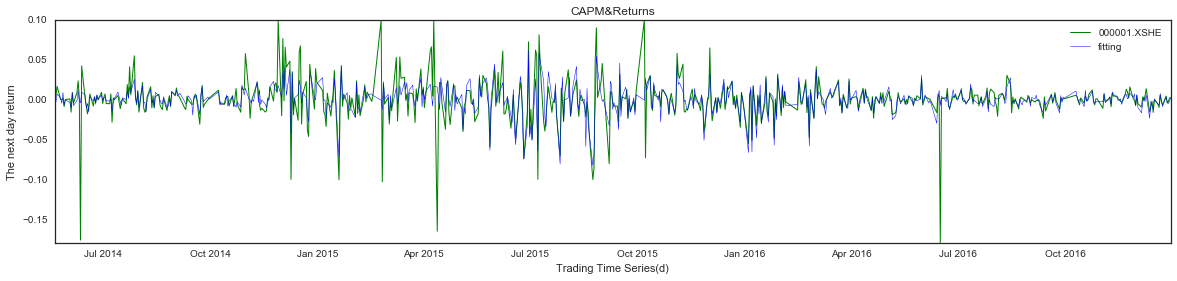

In [148]:
re = rm*beta + alpha 
plt.figure(figsize=(20,4))
plt.plot(tmp.index, tmp['ret'],label="000001.XSHE",color="green",linewidth=1.)
plt.plot(tmp.index, re, label="fitting",color="blue",linewidth=.5)
plt.ylim([-0.1,0.1])
plt.xlabel("Trading Time Series(d)")
plt.ylabel("The next day return")
plt.title("CAPM&Returns")
plt.axis('tight')
plt.legend()
plt.show()

上面的使用数年的数据进行拟合,下面使用一个简单的线型模型对数据进行滚动区段拟合

In [149]:
lrm = r_m['alpha'].values
lrp = tmp['ret'].values
ltmp = pd.DataFrame([lrm,lrp],index=['rm','rp']).T
# 对平安银行进行区段滚动拟合
list_alpha = []
list_beta = []
list_stderr = []
for i in ltmp.index[60:]:
    temp = np.array(ltmp.iloc[i-60:i])
    beta, alpha, rvalue, pvalue, stderr = stats.linregress(temp)
    list_alpha.append(alpha)
    list_beta.append(beta)
    list_stderr.append(stderr)
    
tp = pd.DataFrame([list_alpha, list_beta, list_stderr], index=['alpha','beta','stderr']).T

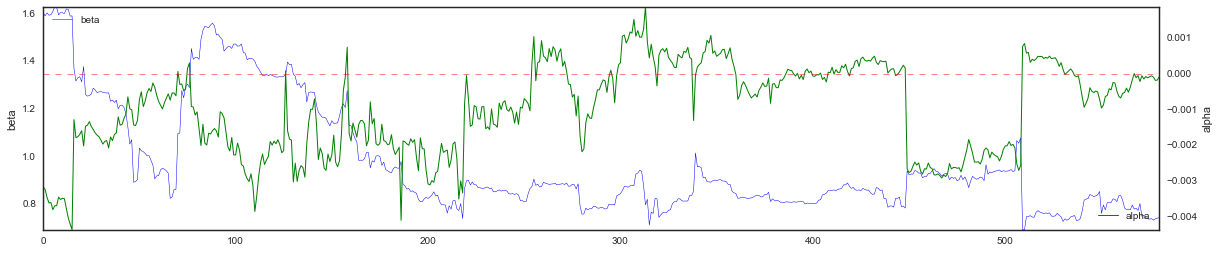

In [150]:
fig, ax1 = plt.subplots(figsize=(20,4))
plt.plot(tp.index, tp.beta, label="beta",color="blue",linewidth=.5)
plt.ylabel("beta")
plt.legend(loc='upper left')
plt.axis('tight')
ax2 = ax1.twinx()
plt.plot(tp.index, tp.alpha, label="alpha",color="green",linewidth=1.)
plt.axhline(linewidth=.5,linestyle='--', color='r')
plt.xlabel("Trading Time Series(d)")
plt.ylabel("alpha")
plt.legend(loc='lower right')
plt.axis('tight')
plt.show()

可以看到线性回归模型中偏置在0分界线附近震荡，从长周期看。强行假设成一个震荡波，设置HS300为基准，则个股出现回归基准线的趋势。
假想$\alpha <0$ 个股相对基准低估 $\alpha >0$个股相对基准高估，做多低估，做空高估。

In [151]:
df = ts.get_stock_basics()

In [153]:
date = df.ix['600848']['timeToMarket'] #上市日期YYYYMMDD

In [154]:
date

19940324

In [155]:
ts.get_h_data('002337') #前复权

[Getting data:]####

C:\Anaconda2\lib\site-packages\tushare\stock\trading.py:446: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort('date', ascending=False)


open  high  close   low    volume     amount
date                                                    
2017-05-17  6.20  6.27   6.17  6.14   3483113   21599144
2017-05-16  6.08  6.20   6.20  5.95   3443576   20909894
2017-05-15  6.05  6.10   6.09  6.02   2087855   12679786
2017-05-12  6.02  6.15   6.05  5.96   3791785   22998697
2017-05-11  6.17  6.17   6.03  5.83   5157900   30912421
2017-05-10  6.27  6.35   6.17  6.12   2837487   17752726
2017-05-09  6.27  6.35   6.29  6.20   2651669   16606667
2017-05-08  6.34  6.39   6.26  6.22   2822171   17798194
2017-05-05  6.51  6.58   6.42  6.40   4166067   26951271
2017-05-04  6.42  6.97   6.60  6.35   6609603   44191686
2017-05-03  6.47  6.49   6.44  6.39   2439167   15664461
2017-05-02  6.45  6.48   6.47  6.39   2373569   15287845
2017-04-28  6.38  6.47   6.45  6.34   2355027   15115560
2017-04-27  6.40  6.42   6.40  6.17   3669741   23117043
2017-04-26  6.49  6.49   6.37  6.35   3321251   21228602
2017-04-25  6.43  6.50   6.46  6.42   2124700   13730491
2017-04-24  6.66  6.71   6.42  6.39   4784917   31188545
2017-04-21  6.72  6.76   6.66  6.64   2702015   18111637
2017-04-20  6.80  6.84   6.73  6.57   6205222   41387248
2017-04-19  6.92  6.92   6.82  6.62   4248194   28718340
2017-04-18  7.04  7.04   6.92  6.85   3844976   26691322
2017-04-17  7.07  7.07   6.97  6.92   4299948   29978241
2017-04-14  7.24  7.26   7.07  7.05   4942897   35256523
2017-04-13  7.22  7.30   7.24  7.16   4173640   30116211
2017-04-12  7.36  7.40   7.22  7.18   7528288   54663442
2017-04-11  7.29  7.45   7.42  7.21   8011904   58951742
2017-04-10  7.25  7.47   7.30  7.19   8000843   58654755
2017-04-07  7.22  7.30   7.26  7.19   4666717   33841004
2017-04-06  7.34  7.35   7.22  7.18   6279947   45467074
2017-04-05  7.04  7.37   7.34  7.04   9585097   69549767
...          ...   ...    ...   ...       ...        ...
2016-06-30  7.85  7.91   7.80  7.75   9274096   72599734
2016-06-29  7.78  7.95   7.89  7.72  16722026  131429173
2016-06-28  7.65  7.80   7.76  7.59  11808203   91132450
2016-06-27  7.38  7.73   7.69  7.35  11218167   85268827
2016-06-24  7.78  7.97   7.56  7.32  19283031  148245167
2016-06-23  7.65  7.77   7.77  7.50  14079371  108201179
2016-06-22  7.36  7.66   7.65  7.36   7324508   55276524
2016-06-21  7.55  7.76   7.43  7.36   8269502   62780462
2016-06-20  7.51  7.63   7.53  7.43   4538663   34121935
2016-06-17  7.53  7.66   7.53  7.49   6195952   47035646
2016-06-16  7.49  7.74   7.53  7.43   9718612   73712167
2016-06-15  7.20  7.48   7.46  7.15   5984268   44149853
2016-06-14  7.16  7.29   7.25  7.10   3509497   25283083
2016-06-13  7.58  7.64   7.20  7.20   8828170   65794010
2016-06-08  7.73  7.73   7.68  7.61   5489135   42086930
2016-06-07  7.66  7.78   7.74  7.61   7159999   55200425
2016-06-06  7.72  7.79   7.63  7.56   7513076   57530163
2016-06-03  7.66  7.85   7.71  7.59  13256444  102480625
2016-06-02  7.65  7.80   7.67  7.58  16773356  129092427
2016-06-01  7.45  7.70   7.69  7.41  14695442  111474073
2016-05-31  7.18  7.46   7.45  7.18   9357574   69069811
2016-05-30  7.30  7.32   7.16  7.16   4586611   33128276
2016-05-27  7.28  7.35   7.29  7.22   5526221   40345284
2016-05-26  7.47  7.49   7.38  7.13   9904340   72018090
2016-05-25  7.24  7.58   7.45  7.18  15252969  112538914
2016-05-24  7.18  7.23   7.15  7.09   3466833   24776288
2016-05-23  7.19  7.26   7.23  7.15   4084884   29468538
2016-05-20  7.03  7.17   7.15  6.96   4230889   30004972
2016-05-19  7.09  7.25   7.10  7.09   4242717   30453250
2016-05-18  7.38  7.38   7.09  7.00   5751957   41269040

[243 rows x 6 columns]

In [156]:

ts.get_h_data('002337', autype=None) #不复权

[Getting data:]####[Getting data:]####

open  high  close   low    volume     amount
date                                                    
2017-05-17  6.20  6.27   6.17  6.14   3483113   21599144
2017-05-16  6.08  6.20   6.20  5.95   3443576   20909894
2017-05-15  6.05  6.10   6.09  6.02   2087855   12679786
2017-05-12  6.02  6.15   6.05  5.96   3791785   22998697
2017-05-11  6.17  6.17   6.03  5.83   5157900   30912421
2017-05-10  6.27  6.35   6.17  6.12   2837487   17752726
2017-05-09  6.27  6.35   6.29  6.20   2651669   16606667
2017-05-08  6.34  6.39   6.26  6.22   2822171   17798194
2017-05-05  6.51  6.58   6.42  6.40   4166067   26951271
2017-05-04  6.42  6.97   6.60  6.35   6609603   44191686
2017-05-03  6.47  6.49   6.44  6.39   2439167   15664461
2017-05-02  6.45  6.48   6.47  6.39   2373569   15287845
2017-04-28  6.38  6.47   6.45  6.34   2355027   15115560
2017-04-27  6.40  6.42   6.40  6.17   3669741   23117043
2017-04-26  6.49  6.49   6.37  6.35   3321251   21228602
2017-04-25  6.43  6.50   6.46  6.42   2124700   13730491
2017-04-24  6.66  6.71   6.42  6.39   4784917   31188545
2017-04-21  6.72  6.76   6.66  6.64   2702015   18111637
2017-04-20  6.80  6.84   6.73  6.57   6205222   41387248
2017-04-19  6.92  6.92   6.82  6.62   4248194   28718340
2017-04-18  7.04  7.04   6.92  6.85   3844976   26691322
2017-04-17  7.07  7.07   6.97  6.92   4299948   29978241
2017-04-14  7.24  7.26   7.07  7.05   4942897   35256523
2017-04-13  7.22  7.30   7.24  7.16   4173640   30116211
2017-04-12  7.36  7.40   7.22  7.18   7528288   54663442
2017-04-11  7.29  7.45   7.42  7.21   8011904   58951742
2017-04-10  7.25  7.47   7.30  7.19   8000843   58654755
2017-04-07  7.22  7.30   7.26  7.19   4666717   33841004
2017-04-06  7.34  7.35   7.22  7.18   6279947   45467074
2017-04-05  7.04  7.37   7.34  7.04   9585097   69549767
...          ...   ...    ...   ...       ...        ...
2016-06-30  7.85  7.91   7.80  7.75   9274096   72599734
2016-06-29  7.78  7.95   7.89  7.72  16722026  131429173
2016-06-28  7.65  7.80   7.76  7.59  11808203   91132450
2016-06-27  7.38  7.73   7.69  7.35  11218167   85268827
2016-06-24  7.78  7.97   7.56  7.32  19283031  148245167
2016-06-23  7.65  7.77   7.77  7.50  14079371  108201179
2016-06-22  7.36  7.66   7.65  7.36   7324508   55276524
2016-06-21  7.55  7.76   7.43  7.36   8269502   62780462
2016-06-20  7.51  7.63   7.53  7.43   4538663   34121935
2016-06-17  7.53  7.66   7.53  7.49   6195952   47035646
2016-06-16  7.49  7.74   7.53  7.43   9718612   73712167
2016-06-15  7.20  7.48   7.46  7.15   5984268   44149853
2016-06-14  7.16  7.29   7.25  7.10   3509497   25283083
2016-06-13  7.58  7.64   7.20  7.20   8828170   65794010
2016-06-08  7.73  7.73   7.68  7.61   5489135   42086930
2016-06-07  7.66  7.78   7.74  7.61   7159999   55200425
2016-06-06  7.72  7.79   7.63  7.56   7513076   57530163
2016-06-03  7.66  7.85   7.71  7.59  13256444  102480625
2016-06-02  7.65  7.80   7.67  7.58  16773356  129092427
2016-06-01  7.45  7.70   7.69  7.41  14695442  111474073
2016-05-31  7.18  7.46   7.45  7.18   9357574   69069811
2016-05-30  7.30  7.32   7.16  7.16   4586611   33128276
2016-05-27  7.28  7.35   7.29  7.22   5526221   40345284
2016-05-26  7.47  7.49   7.38  7.13   9904340   72018090
2016-05-25  7.24  7.58   7.45  7.18  15252969  112538914
2016-05-24  7.18  7.23   7.15  7.09   3466833   24776288
2016-05-23  7.19  7.26   7.23  7.15   4084884   29468538
2016-05-20  7.03  7.17   7.15  6.96   4230889   30004972
2016-05-19  7.09  7.25   7.10  7.09   4242717   30453250
2016-05-18  7.38  7.38   7.09  7.00   5751957   41269040

[243 rows x 6 columns]

In [159]:
ts.get_h_data('002337', autype='qfq') #后复权

[Getting data:]####

open  high  close   low    volume     amount
date                                                    
2017-05-17  6.20  6.27   6.17  6.14   3483113   21599144
2017-05-16  6.08  6.20   6.20  5.95   3443576   20909894
2017-05-15  6.05  6.10   6.09  6.02   2087855   12679786
2017-05-12  6.02  6.15   6.05  5.96   3791785   22998697
2017-05-11  6.17  6.17   6.03  5.83   5157900   30912421
2017-05-10  6.27  6.35   6.17  6.12   2837487   17752726
2017-05-09  6.27  6.35   6.29  6.20   2651669   16606667
2017-05-08  6.34  6.39   6.26  6.22   2822171   17798194
2017-05-05  6.51  6.58   6.42  6.40   4166067   26951271
2017-05-04  6.42  6.97   6.60  6.35   6609603   44191686
2017-05-03  6.47  6.49   6.44  6.39   2439167   15664461
2017-05-02  6.45  6.48   6.47  6.39   2373569   15287845
2017-04-28  6.38  6.47   6.45  6.34   2355027   15115560
2017-04-27  6.40  6.42   6.40  6.17   3669741   23117043
2017-04-26  6.49  6.49   6.37  6.35   3321251   21228602
2017-04-25  6.43  6.50   6.46  6.42   2124700   13730491
2017-04-24  6.66  6.71   6.42  6.39   4784917   31188545
2017-04-21  6.72  6.76   6.66  6.64   2702015   18111637
2017-04-20  6.80  6.84   6.73  6.57   6205222   41387248
2017-04-19  6.92  6.92   6.82  6.62   4248194   28718340
2017-04-18  7.04  7.04   6.92  6.85   3844976   26691322
2017-04-17  7.07  7.07   6.97  6.92   4299948   29978241
2017-04-14  7.24  7.26   7.07  7.05   4942897   35256523
2017-04-13  7.22  7.30   7.24  7.16   4173640   30116211
2017-04-12  7.36  7.40   7.22  7.18   7528288   54663442
2017-04-11  7.29  7.45   7.42  7.21   8011904   58951742
2017-04-10  7.25  7.47   7.30  7.19   8000843   58654755
2017-04-07  7.22  7.30   7.26  7.19   4666717   33841004
2017-04-06  7.34  7.35   7.22  7.18   6279947   45467074
2017-04-05  7.04  7.37   7.34  7.04   9585097   69549767
...          ...   ...    ...   ...       ...        ...
2016-06-30  7.85  7.91   7.80  7.75   9274096   72599734
2016-06-29  7.78  7.95   7.89  7.72  16722026  131429173
2016-06-28  7.65  7.80   7.76  7.59  11808203   91132450
2016-06-27  7.38  7.73   7.69  7.35  11218167   85268827
2016-06-24  7.78  7.97   7.56  7.32  19283031  148245167
2016-06-23  7.65  7.77   7.77  7.50  14079371  108201179
2016-06-22  7.36  7.66   7.65  7.36   7324508   55276524
2016-06-21  7.55  7.76   7.43  7.36   8269502   62780462
2016-06-20  7.51  7.63   7.53  7.43   4538663   34121935
2016-06-17  7.53  7.66   7.53  7.49   6195952   47035646
2016-06-16  7.49  7.74   7.53  7.43   9718612   73712167
2016-06-15  7.20  7.48   7.46  7.15   5984268   44149853
2016-06-14  7.16  7.29   7.25  7.10   3509497   25283083
2016-06-13  7.58  7.64   7.20  7.20   8828170   65794010
2016-06-08  7.73  7.73   7.68  7.61   5489135   42086930
2016-06-07  7.66  7.78   7.74  7.61   7159999   55200425
2016-06-06  7.72  7.79   7.63  7.56   7513076   57530163
2016-06-03  7.66  7.85   7.71  7.59  13256444  102480625
2016-06-02  7.65  7.80   7.67  7.58  16773356  129092427
2016-06-01  7.45  7.70   7.69  7.41  14695442  111474073
2016-05-31  7.18  7.46   7.45  7.18   9357574   69069811
2016-05-30  7.30  7.32   7.16  7.16   4586611   33128276
2016-05-27  7.28  7.35   7.29  7.22   5526221   40345284
2016-05-26  7.47  7.49   7.38  7.13   9904340   72018090
2016-05-25  7.24  7.58   7.45  7.18  15252969  112538914
2016-05-24  7.18  7.23   7.15  7.09   3466833   24776288
2016-05-23  7.19  7.26   7.23  7.15   4084884   29468538
2016-05-20  7.03  7.17   7.15  6.96   4230889   30004972
2016-05-19  7.09  7.25   7.10  7.09   4242717   30453250
2016-05-18  7.38  7.38   7.09  7.00   5751957   41269040

[243 rows x 6 columns]

In [166]:
tmp

open  high  close   low     volume      amount       ret
2013-01-04  5.43  5.47   5.32  5.30   44385136   717567552 -0.001876
2013-01-07  5.32  5.44   5.42  5.28   35716924   578450496  0.018797
2013-01-08  5.42  5.45   5.32  5.28   31247912   501360096 -0.018450
2013-01-09  5.31  5.33   5.28  5.26   25132916   399696192 -0.007519
2013-01-10  5.28  5.36   5.28  5.25   24003028   383347744  0.000000
2013-01-11  5.28  5.34   5.17  5.14   25126856   396184768 -0.020833
2013-01-14  5.15  5.69   5.69  5.15   93989592  1568841984  0.100580
2013-01-15  5.70  5.96   5.86  5.69   98406440  1719308672  0.029877
2013-01-16  5.86  5.96   5.93  5.73   68270096  1198986624  0.011945
2013-01-17  5.89  6.08   5.90  5.81   67577208  1206432384 -0.005059
2013-01-18  5.95  6.13   6.10  5.86   66536764  1201751680  0.033898
2013-01-21  6.09  6.55   6.55  5.99   78213640  1465651584  0.073770
2013-01-22  6.47  6.95   6.81  6.43  106876960  2167549696  0.039695
2013-01-23  6.66  6.79   6.67  6.42   63569848  1266082560 -0.020558
2013-01-24  6.66  6.85   6.47  6.42   85723640  1709191424 -0.029985
2013-01-25  6.49  6.51   6.37  6.30   61431248  1178016256 -0.015456
2013-01-28  6.37  7.01   7.01  6.37  116399520  2365203200  0.100471
2013-01-29  7.09  7.17   7.11  6.86  108289496  2288064768  0.014265
2013-01-30  7.02  7.10   7.10  6.92   58362496  1233766272 -0.001406
2013-01-31  7.08  7.10   7.02  6.92   41588420   873902912 -0.011268
2013-02-01  6.99  7.50   7.46  6.92   82408048  1793445760  0.062678
2013-02-04  7.41  7.58   7.32  7.22   85742000  1906659456 -0.018767
2013-02-05  7.23  7.37   7.25  7.05   42689100   927037952 -0.009563
2013-02-06  7.22  7.31   7.27  7.14   38082656   827479680  0.002759
2013-02-07  7.22  7.26   6.94  6.76   58612692  1230117760 -0.045392
2013-02-08  6.91  7.00   6.90  6.78   46202464   958773568 -0.005764
2013-02-18  6.96  7.15   6.95  6.90   42181312   887486912  0.007246
2013-02-19  6.92  7.02   6.92  6.88   48650848  1017085056 -0.004317
2013-02-20  6.94  6.98   6.75  6.55   65915768  1324230528 -0.024566
2013-02-21  6.65  6.65   6.52  6.34   74024480  1445657216 -0.034074
...          ...   ...    ...   ...        ...         ...       ...
2016-11-21  8.85  8.94   8.90  8.84   85024326   785475677  0.005650
2016-11-22  8.90  9.02   9.02  8.90  118025694  1097408714  0.013483
2016-11-23  9.00  9.21   9.11  9.00  175286943  1660465709  0.009978
2016-11-24  9.10  9.17   9.13  9.08   77974884   738580569  0.002195
2016-11-25  9.14  9.27   9.27  9.12  101367499   968127766  0.015334
2016-11-28  9.34  9.43   9.28  9.25  127968924  1240686234  0.001079
2016-11-29  9.24  9.35   9.27  9.20   88777923   854308658 -0.001078
2016-11-30  9.30  9.37   9.20  9.16  102596305   985758450 -0.007551
2016-12-01  9.22  9.28   9.25  9.20   64600437   619633747  0.005435
2016-12-02  9.25  9.25   9.20  9.10   82968650   790044442 -0.005405
2016-12-05  9.16  9.19   9.12  9.07   76436570   723222054 -0.008696
2016-12-06  9.14  9.17   9.15  9.11   60290276   571585178  0.003289
2016-12-07  9.14  9.15   9.14  9.07   49340476   466085503 -0.001093
2016-12-08  9.16  9.20   9.17  9.09   67145216   638058504  0.003282
2016-12-09  9.16  9.40   9.30  9.14  151419915  1460778328  0.014177
2016-12-12  9.30  9.42   9.16  9.10  125687400  1206662617 -0.015054
2016-12-13  9.14  9.16   9.08  8.99   64577157   607769966 -0.008734
2016-12-14  9.08  9.17   9.06  9.06   59770574   564787516 -0.002203
2016-12-15  9.03  9.07   8.91  8.88   82761287   767751836 -0.016556
2016-12-16  8.90  8.95   8.91  8.88   39681397   366925349  0.000000
2016-12-19  8.89  8.90   8.87  8.84   49401064   453899744 -0.004489
2016-12-20  8.87  8.87   8.78  8.75   63663837   580118168 -0.010147
2016-12-21  8.79  8.83   8.83  8.78   36992065   338201446  0.005695
2016-12-22  8.82  8.83   8.81  8.78   34134124   311546857 -0.002265
2016-12-23  8.81  8.81   8.75  8.74   38291216   348140451 -0.006810
2016-12-26  8.73  8.80   8.79  8.69   30205896   273934287  0.004571
2016-12-27